# Clase 14: Audio como dato (Assignment)

**Ingeniería de Datos — Universidad Católica del Uruguay**

**Objetivo:** Diseñar e implementar un pipeline de preprocesamiento de audio que incorpore carga, inspección visual, limpieza básica, extracción de MFCC y exportación de features listos para ML.


## Setup y Carga de Datos

### Instalación rápida


In [1]:
!pip install -q librosa soundfile numpy matplotlib pandas scipy

import librosa
import librosa.display
import soundfile as sf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import pathlib, warnings, platform, os

warnings.filterwarnings("ignore")

print("✅ Librerías listas")
print(f"librosa: {librosa.__version__}")
print(f"soundfile: {sf.__libs__ if hasattr(sf, '__libs__') else 'OK'}")
print(f"Python: {platform.python_version()}")


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


✅ Librerías listas
librosa: 0.11.0
soundfile: OK
Python: 3.13.5


### 0) Dataset

**Nota:** Este notebook está adaptado para entorno local. Vamos a trabajar con archivos de audio de ejemplo o un subset del dataset UrbanSound8K si lo tienes descargado localmente.


In [2]:
# Opción 1: Si tienes el dataset UrbanSound8K localmente
# RAW_DIR = Path(r"C:\ruta\al\dataset\UrbanSound8K")

# Opción 2: Crear audios sintéticos para demostración
from pathlib import Path
import numpy as np
import soundfile as sf

# Crear directorio de datos si no existe
data_dir = Path("data/raw")
data_dir.mkdir(parents=True, exist_ok=True)

# Generar algunos audios sintéticos para demostración
print("Generando audios sintéticos de ejemplo...")
for i in range(5):
    # Generar señal de audio sintética (tone + ruido)
    sr = 22050
    duration = 4.0
    t = np.linspace(0, duration, int(sr * duration))
    
    # Tono puro + ruido
    freq = 440 + i * 100  # frecuencias diferentes
    signal_audio = 0.3 * np.sin(2 * np.pi * freq * t) + 0.1 * np.random.randn(len(t))
    
    # Guardar
    output_path = data_dir / f"sample_audio_{i+1}.wav"
    sf.write(output_path, signal_audio.astype(np.float32), sr)
    
print(f"✅ Audios sintéticos creados en: {data_dir.absolute()}")

Generando audios sintéticos de ejemplo...
✅ Audios sintéticos creados en: c:\Users\arias\Desktop\Data Engineer\Ingenieria-de-datos-1\Practicos\data\raw


In [3]:
# Cargar los archivos de audio disponibles
RAW_DIR = Path("data/raw")

audio_files = sorted([
    p for p in RAW_DIR.glob("**/*")
    if p.suffix.lower() in {".wav", ".mp3", ".flac", ".ogg"}
])

print("Audios encontrados:", len(audio_files))
if audio_files:
    print("\nPrimeros archivos:")
    for f in audio_files[:5]:
        print(f"  - {f.name}")

Audios encontrados: 5

Primeros archivos:
  - sample_audio_1.wav
  - sample_audio_2.wav
  - sample_audio_3.wav
  - sample_audio_4.wav
  - sample_audio_5.wav


### 1) Directorios de trabajo


In [4]:
OUTPUTS = {
    "waveforms": pathlib.Path("outputs/waveforms"),
    "specs": pathlib.Path("outputs/specs"),
    "features": pathlib.Path("outputs/features"),
    "metrics": pathlib.Path("outputs/metrics"),
}

for out in OUTPUTS.values():
    out.mkdir(parents=True, exist_ok=True)

print("Carpetas de salida creadas")

Carpetas de salida creadas


## Parte A — Representación e inspección inicial

### A.1 Carga y stats básicas


In [5]:
from pathlib import Path

def load_audio(path: Path, sr: int | None = None, mono: bool = False):
    y, sr = librosa.load(path.as_posix(), sr=sr, mono=mono)
    return y, sr

assert audio_files, "No hay audios en data/raw"
audio_path = audio_files[0]

y, sr = load_audio(audio_path, sr=None, mono=False)
print("Archivo:", audio_path.name)
print("Forma:", y.shape, "dtype:", y.dtype)
print("Sample rate original:", sr)

duration_sec = len(y) / sr if y.ndim == 1 else y.shape[-1] / sr
channels = 1 if y.ndim == 1 else y.shape[0]

if y.ndim > 1:
    y_mono = np.mean(y, axis=0)
else:
    y_mono = y

print("Duración (s):", round(duration_sec, 3))
print("Canales:", channels)
print("Amplitud min/max:", round(float(y_mono.min()), 4),
      round(float(y_mono.max()), 4))
print("Media:", round(float(y_mono.mean()), 4),
      "STD:", round(float(y_mono.std()), 4))

Archivo: sample_audio_1.wav
Forma: (88200,) dtype: float32
Sample rate original: 22050
Duración (s): 4.0
Canales: 1
Amplitud min/max: -0.6855 0.7091
Media: -0.0001 STD: 0.2342


### A.2 Waveform en el tiempo


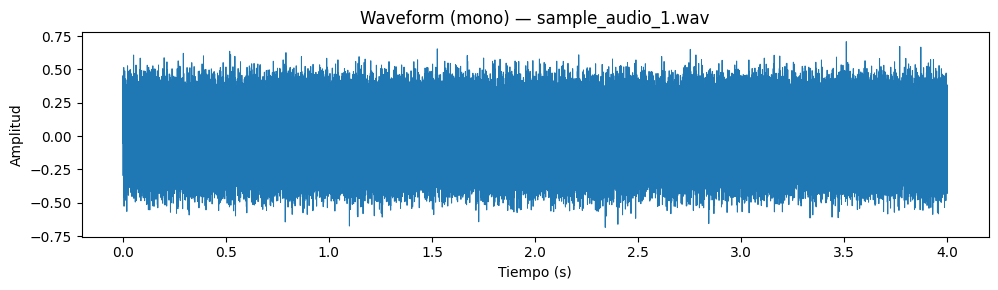

In [6]:
t = np.linspace(0, duration_sec, num=y_mono.shape[-1])
plt.figure(figsize=(10, 3))
plt.plot(t, y_mono, linewidth=0.7)
plt.title(f"Waveform (mono) — {audio_path.name}")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.tight_layout()
plt.show()

### 📝 Preguntas de reflexión — Parte A

1. El audio dura aproximadamente **\_** segundos y tiene sample rate **\_** Hz.

2. La amplitud oscila entre **\_** y **\_**, lo que indica que el clip está (a) normalizado / (b) no normalizado porque **\_**.

3. El número de canales es **\_**; trabajar en mono es adecuado/no adecuado porque **\_**.

4. El tipo de dato (dtype) de `y` es **\_** y los valores típicos están en el rango [___, ___]; esto sugiere que la señal está / no está normalizada porque **\_**.

5. Si observáramos muchos valores cerca de -1.0 o +1.0, esto indicaría potencialmente clipping / ausencia de clipping, lo cual es problemático porque **\_**.


## Parte B — Estandarización del audio

**Objetivo:** unificar sample rate, mono, duración y amplitud para alimentar el pipeline.


In [7]:
TARGET_SR = 16000          # Hz
TARGET_DURATION = 3.0      # segundos
TARGET_AMPLITUDE = 0.99
TOP_DB = 30.0              # recorte de silencios

def preprocess_audio(path: Path,
                     target_sr: int = TARGET_SR,
                     target_duration: float = TARGET_DURATION,
                     top_db: float = TOP_DB) -> tuple[np.ndarray, int]:
    y, sr = load_audio(path, sr=None, mono=False)

    if y.ndim > 1:
        y = np.mean(y, axis=0)

    y_trim, _ = librosa.effects.trim(y, top_db=top_db)

    if sr != target_sr:
        y_rs = librosa.resample(y_trim, orig_sr=sr, target_sr=target_sr)
    else:
        y_rs = y_trim

    target_len = int(target_sr * target_duration)
    if len(y_rs) > target_len:
        y_rs = y_rs[:target_len]
    elif len(y_rs) < target_len:
        pad_width = target_len - len(y_rs)
        y_rs = np.pad(y_rs, (0, pad_width))

    max_abs = np.max(np.abs(y_rs)) or 1.0
    y_norm = (TARGET_AMPLITUDE * y_rs) / max_abs

    return y_norm.astype(np.float32), target_sr

y_std, sr_std = preprocess_audio(audio_path)
print("Forma procesada:", y_std.shape, "sr:", sr_std)
print("Duración procesada (s):", round(len(y_std) / sr_std, 3))
print("Amplitud procesada min/max:", round(float(y_std.min()), 4),
      round(float(y_std.max()), 4))

Forma procesada: (48000,) sr: 16000
Duración procesada (s): 3.0
Amplitud procesada min/max: -0.9747 0.99


### B.2 Waveform original vs estandarizado


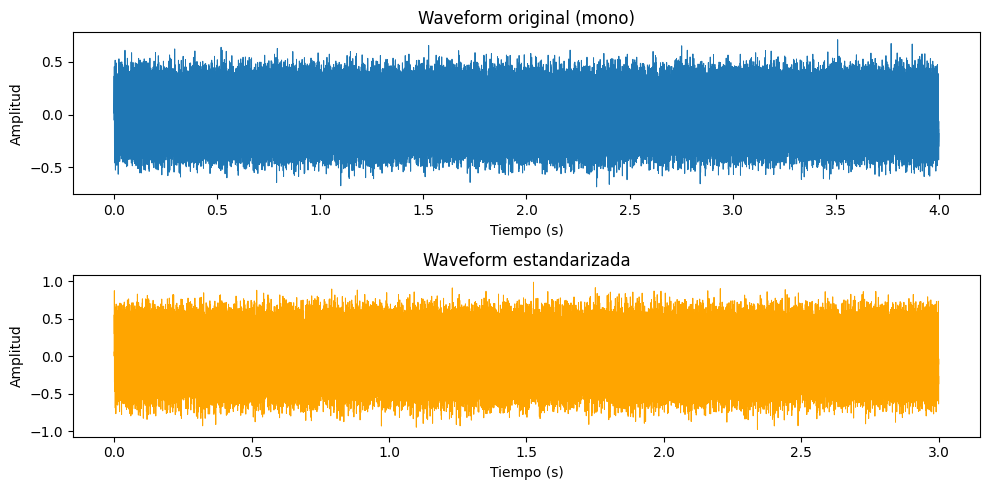

In [8]:
t_orig = np.linspace(0, duration_sec, num=y_mono.shape[-1])
t_std = np.linspace(0, TARGET_DURATION, num=y_std.shape[-1])

fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=False)
axes[0].plot(t_orig, y_mono, linewidth=0.7)
axes[0].set_title("Waveform original (mono)")
axes[0].set_xlabel("Tiempo (s)")
axes[0].set_ylabel("Amplitud")

axes[1].plot(t_std, y_std, linewidth=0.7, color="orange")
axes[1].set_title("Waveform estandarizada")
axes[1].set_xlabel("Tiempo (s)")
axes[1].set_ylabel("Amplitud")

plt.tight_layout()
plt.show()

### 📝 Preguntas de reflexión — Parte B

1. Elegí `TARGET_SR = 16000 Hz` porque: (a) es suficiente para voz y sonidos de interés y (b) reduce el tamaño respecto a 44.1 kHz porque **\_**.

2. El recorte de silencios con `top_db = 30` eliminó principalmente: (a) silencios muy suaves / (b) parte de la señal útil. Justifico: **\_**.

3. La normalización hace que el pico quede cerca de 0.99, lo cual ayuda a **\_**.

4. Si aumentáramos `TARGET_DURATION` a **\_** s, el número de muestras por clip sería de aproximadamente `TARGET_SR × duración = _____`, lo que impacta en el tamaño en disco y memoria porque **\_**.

5. Si en vez de recortar/padear desde el inicio recortáramos siempre el centro del clip, esto sería mejor/peor para este dataset porque **\_**.


## Parte C — Espectrogramas y ruido

### C.1 Espectrograma de potencia


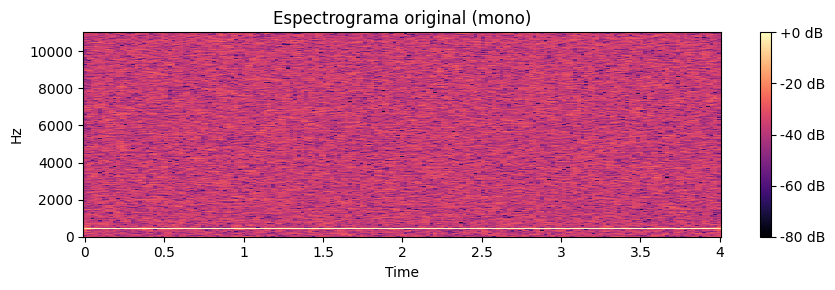

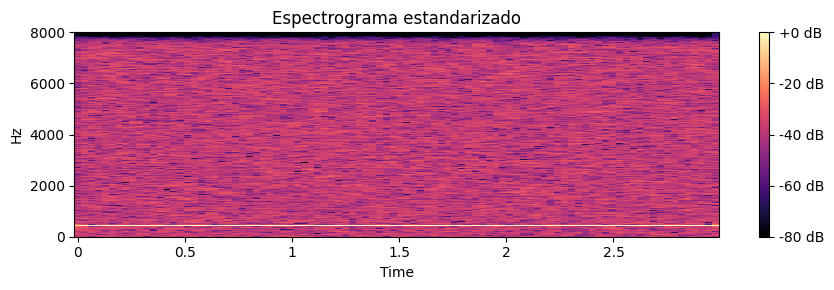

In [9]:
def plot_spectrogram(y: np.ndarray, sr: int, title: str = "") -> np.ndarray:
    n_fft = 2048
    hop_length = 512
    D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    plt.figure(figsize=(9, 3))
    librosa.display.specshow(
        S_db, sr=sr, hop_length=hop_length, x_axis="time", y_axis="hz"
    )
    plt.colorbar(format="%+2.0f dB")
    plt.title(title)
    plt.tight_layout()
    plt.show()
    return S_db

S_db_orig = plot_spectrogram(y_mono, sr, title="Espectrograma original (mono)")
S_db_std = plot_spectrogram(y_std, sr_std, title="Espectrograma estandarizado")

Para más detalles sobre STFT y espectrogramas, ver:

- `librosa.stft`: https://librosa.org/doc/latest/generated/librosa.stft.html
- Tutorial de espectrogramas: https://librosa.org/doc/latest/feature_extraction.html#spectral-features

### C.2 Ruido y SNR


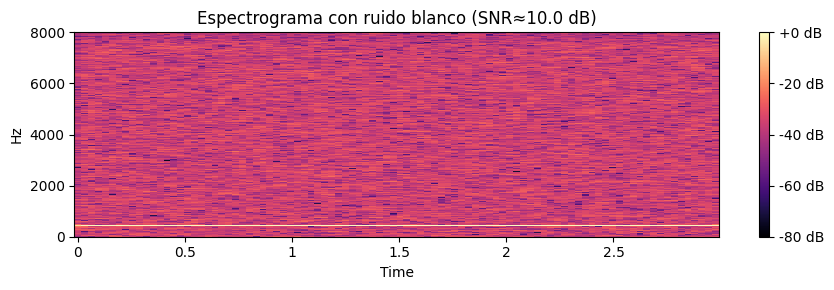

In [10]:
def add_white_noise(y: np.ndarray, snr_db: float) -> np.ndarray:
    sig_power = np.mean(y**2)
    snr_linear = 10**(snr_db / 10)
    noise_power = sig_power / snr_linear
    noise = np.sqrt(noise_power) * np.random.randn(*y.shape)
    return (y + noise).astype(np.float32)

snr_target_db = 10.0
y_noisy = add_white_noise(y_std, snr_db=snr_target_db)
S_db_noisy = plot_spectrogram(
    y_noisy, sr_std, title=f"Espectrograma con ruido blanco (SNR≈{snr_target_db} dB)"
)

### C.3 High-pass para ruido grave


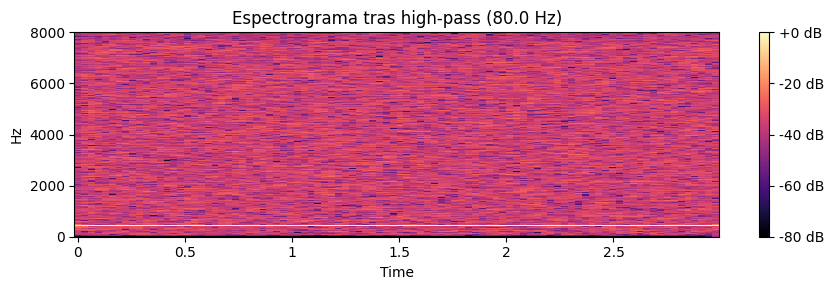

In [11]:
def butter_highpass(cutoff_hz: float, sr: int, order: int = 4):
    nyq = 0.5 * sr
    norm_cutoff = cutoff_hz / nyq
    b, a = signal.butter(order, norm_cutoff, btype="high", analog=False)
    return b, a

def highpass_filter(y: np.ndarray, sr: int, cutoff_hz: float = 80.0, order: int = 4):
    b, a = butter_highpass(cutoff_hz, sr, order)
    return signal.lfilter(b, a, y)

cutoff = 80.0
y_hp = highpass_filter(y_noisy, sr_std, cutoff_hz=cutoff, order=4)
S_db_hp = plot_spectrogram(
    y_hp, sr_std, title=f"Espectrograma tras high-pass ({cutoff} Hz)"
)

### 📝 Preguntas de reflexión — Parte C

1. El ruido blanco se observa como **\_** en el espectrograma (describe color/patrón).

2. El filtro high-pass con corte en 80 Hz: (a) eliminó energía por debajo de **\_** Hz. (b) afectó poco/mucho la señal útil porque **\_**.

3. Para eliminar hum de red usaría: (a) un filtro notch en 50 o 60 Hz o (b) un high-pass con corte en \_\_\_\_ Hz. Explicá qué elegirías y por qué.

4. Con `n_fft = 2048` y `hop_length = 512`, cada frame de la STFT cubre aproximadamente **\_** ms. Si quisiéramos mayor resolución temporal, podríamos usar `n_fft = _____` y `hop_length = _____`, a costa de **\_**.


## Parte D — Extracción de MFCC y CSV

### D.1 MFCC agregados


In [12]:
def extract_mfcc_features(y: np.ndarray, sr: int, n_mfcc: int = 13) -> dict:
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    feats = {}
    for i in range(n_mfcc):
        coef = mfcc[i, :]
        feats[f"mfcc_{i+1}_mean"] = float(np.mean(coef))
        feats[f"mfcc_{i+1}_std"] = float(np.std(coef))
    feats["rms_mean"] = float(np.mean(librosa.feature.rms(y=y)))
    feats["zcr_mean"] = float(np.mean(librosa.feature.zero_crossing_rate(y=y)))
    return feats

feats_example = extract_mfcc_features(y_std, sr_std)
print("Features de ejemplo:", len(feats_example))
print(list(feats_example.items())[:5])

Features de ejemplo: 28
[('mfcc_1_mean', 31.087299346923828), ('mfcc_1_std', 2.9568238258361816), ('mfcc_2_mean', 8.14694881439209), ('mfcc_2_std', 3.965602397918701), ('mfcc_3_mean', 3.431563377380371)]


Referencias recomendadas:

- `librosa.feature.mfcc`: https://librosa.org/doc/latest/generated/librosa.feature.mfcc.html
- Tutorial de MFCC: https://librosa.org/doc/latest/feature_extraction.html#mel-frequency-cepstral-coefficients-mfccs

### D.2 Pipeline sobre todos los audios


In [13]:
rows = []
for path in audio_files[:100]:
    try:
        y_proc, sr_proc = preprocess_audio(path)
        feats = extract_mfcc_features(y_proc, sr_proc)
        feats["filename"] = path.name
        feats["sr"] = sr_proc
        feats["duration_sec"] = TARGET_DURATION
        rows.append(feats)
    except Exception as exc:
        print("Error con", path.name, "→", exc)

df_features = pd.DataFrame(rows)
df_features.head()

,mfcc_1_mean,mfcc_1_std,mfcc_2_mean,mfcc_2_std,mfcc_3_mean,mfcc_3_std,mfcc_4_mean,mfcc_4_std,mfcc_5_mean,mfcc_5_std,...,mfcc_11_std,mfcc_12_mean,mfcc_12_std,mfcc_13_mean,mfcc_13_std,rms_mean,zcr_mean,filename,sr,duration_sec
0,31.087299,2.956824,8.146949,3.965602,3.431563,2.971556,4.811277,3.150313,-4.436079,2.906350,...,2.497227,4.924968,2.493433,3.574804,2.782352,0.372101,0.108887,sample_audio_1.wav,16000,3.0
1,22.870556,3.427212,8.092852,2.758808,2.022127,2.723263,2.075739,2.665931,-7.765247,2.452519,...,2.598363,12.188667,2.975414,6.417627,2.465246,0.342167,0.114284,sample_audio_2.wav,16000,3.0
2,23.624556,3.055230,6.937491,3.379698,-0.168138,2.835216,-0.921511,2.733498,-8.979611,3.334958,...,3.029598,7.078670,3.029837,-2.633556,3.038010,0.346036,0.119281,sample_audio_3.wav,16000,3.0
3,30.395855,3.317372,7.148752,3.975542,-1.483624,2.348694,-3.525299,2.866589,-11.388600,3.083595,...,2.871262,-2.826668,2.859174,-11.729389,3.046350,0.365234,0.126704,sample_audio_4.wav,16000,3.0
4,28.333376,3.031639,5.936929,3.222517,-4.014879,2.708674,-6.059064,3.376851,-11.393694,3.257851,...,2.588485,-7.908735,2.533841,-8.030306,2.828010,0.361481,0.132122,sample_audio_5.wav,16000,3.0


### D.3 Guardar CSV


In [14]:
out_csv = OUTPUTS["features"] / "audio_mfcc_features.csv"
df_features.to_csv(out_csv, index=False)
print("✅ Features guardados en:", out_csv)
print("Shape:", df_features.shape)

✅ Features guardados en: outputs\features\audio_mfcc_features.csv
Shape: (5, 31)


### 📝 Preguntas de reflexión — Parte D

1. Elegí `n_mfcc = 13` porque: (a) es un valor típico en voz y (b) más coeficientes agregan detalle pero también riesgo de sobreajuste por **\_**.

2. `mfcc_1_mean` captura: (a) energía global / (b) textura fina. Justifico: **\_**.

3. Para modelar clasificaciones agregarías columnas con: (a) etiquetas provenientes de **\_** y (b) alguna medida extra de ruido como **\_**.

4. Antes de entrenar un modelo supervisado con estos features, convendría aplicar una transformación como StandardScaler / MinMaxScaler porque **\_**. (Ver https://scikit-learn.org/stable/modules/preprocessing.html).


## Parte E — Exploraciones avanzadas (celda extra)

### E.1 Métricas espectrales adicionales


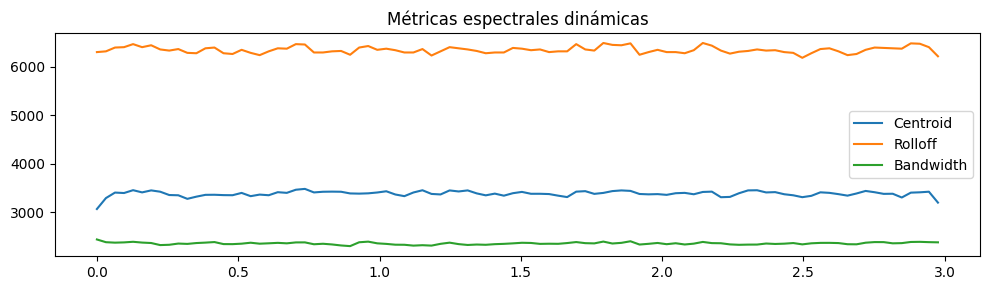

In [15]:
def plot_spectral_metrics(y: np.ndarray, sr: int):
    cent = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85)[0]
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]
    t = librosa.times_like(cent, sr=sr)

    plt.figure(figsize=(10, 3))
    plt.plot(t, cent, label="Centroid")
    plt.plot(t, rolloff, label="Rolloff")
    plt.plot(t, bandwidth, label="Bandwidth")
    plt.legend()
    plt.title("Métricas espectrales dinámicas")
    plt.tight_layout()
    plt.show()

plot_spectral_metrics(y_std, sr_std)

### E.2 Características del dataset


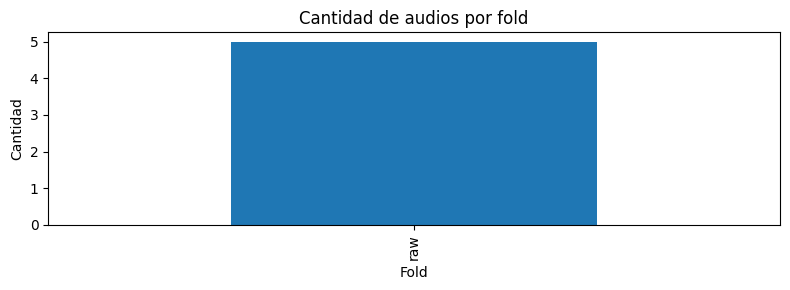

Clips por fold:
 raw    5
Name: count, dtype: int64


In [16]:
import pandas as pd

folds = [p.parent.name for p in audio_files]
summary = pd.Series(folds).value_counts().sort_index()
summary.plot(kind="bar", figsize=(8, 3), title="Cantidad de audios por fold")
plt.xlabel("Fold")
plt.ylabel("Cantidad")
plt.tight_layout()
plt.show()

print("Clips por fold:\n", summary)

Diseñá un esquema para etiquetar algunos archivos (por clase, ambiente, etc.) y combiná esas etiquetas con el CSV de MFCC para un modelo rápido.

### E.3 Augmentación básica


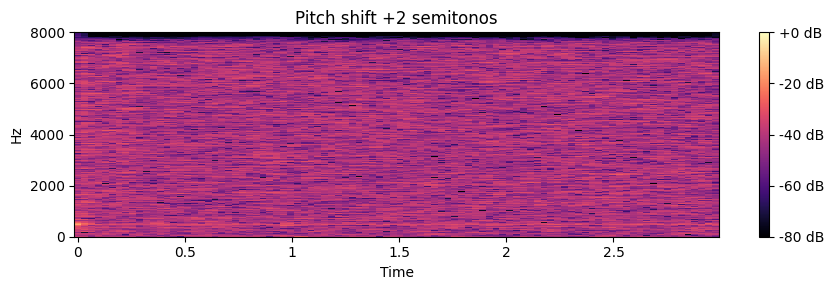

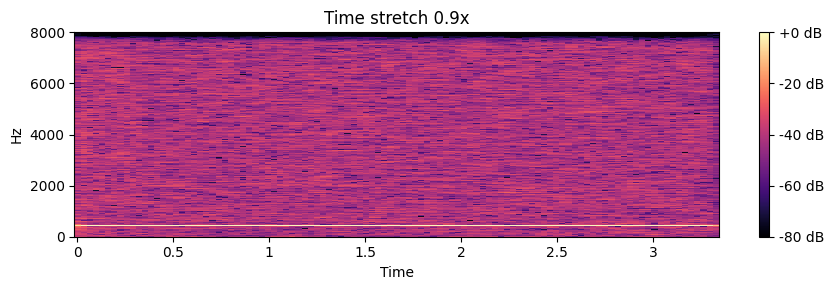

array([[-35.22589 , -42.339302, -48.215977, ..., -39.17686 , -64.244064,
        -47.849476],
       [-35.57426 , -35.716393, -41.98707 , ..., -39.882957, -48.582317,
        -46.910465],
       [-40.300823, -35.100098, -37.916843, ..., -36.437225, -41.796597,
        -44.033672],
       ...,
       [-76.492096, -80.      , -80.      , ..., -80.      , -74.40688 ,
        -74.238525],
       [-76.53066 , -80.      , -80.      , ..., -80.      , -75.94338 ,
        -76.8607  ],
       [-76.5164  , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ]], shape=(1025, 105), dtype=float32)

In [17]:
def augment_pitch_shift(y: np.ndarray, sr: int, steps: int):
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=steps)

y_pitch = augment_pitch_shift(y_std, sr_std, steps=2)
plot_spectrogram(y_pitch, sr_std, title="Pitch shift +2 semitonos")

y_time = librosa.effects.time_stretch(y_std, rate=0.9)
plot_spectrogram(y_time, sr_std, title="Time stretch 0.9x")

Añadí los MFCC de cada versión aumentada al dataframe y compará cómo cambian las medias/STD.

---

## Preguntas de reflexión finales

1. El estándar de entrada fue:

   - sample rate = 16000 Hz
   - duración fija = 3.0 s
   - mono = sí, porque **\_**.

2. El paso que más mejoró la calidad perceptual fue **\_** porque: (a) redujo **\_** y (b) mantuvo **\_**.

3. En el espectrograma detecté ruido de tipo:

   - (a) blanco / (b) hum / (c) impulsivo en la banda de **\_** Hz.

4. Checks automáticos propuestos:
   - SNR aproximado > 15 dB
   - duración ∈ [2.5, 3.5] s
   - max(|amplitud|) ≤ 1.0
   - número de frames MFCC > 30


## Tareas extra (opcional, con celdas guía)

### F.1 Curva SNR → cambio en features


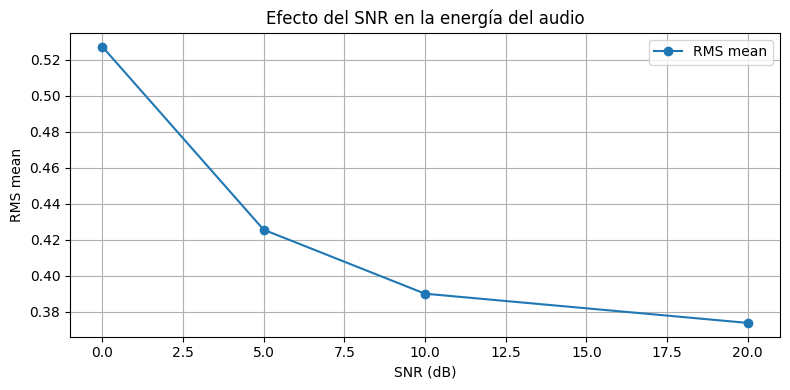

In [18]:
snr_values = [0, 5, 10, 20]
rows_snr = []

for snr_db in snr_values:
    y_noisy_i = add_white_noise(y_std, snr_db=snr_db)
    feats_i = extract_mfcc_features(y_noisy_i, sr_std)
    feats_i["snr_db"] = snr_db
    rows_snr.append(feats_i)

df_snr = pd.DataFrame(rows_snr)
df_snr[["snr_db", "rms_mean", "zcr_mean"] + [c for c in df_snr.columns if "mfcc_1" in c]]

plt.figure(figsize=(8, 4))
plt.plot(df_snr["snr_db"], df_snr["rms_mean"], marker="o", label="RMS mean")
plt.xlabel("SNR (dB)")
plt.ylabel("RMS mean")
plt.title("Efecto del SNR en la energía del audio")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Extensión: agregá gráficos similares para la varianza de `mfcc_1` o para otra feature que te interese.

### F.2 Benchmark de pipelines de limpieza


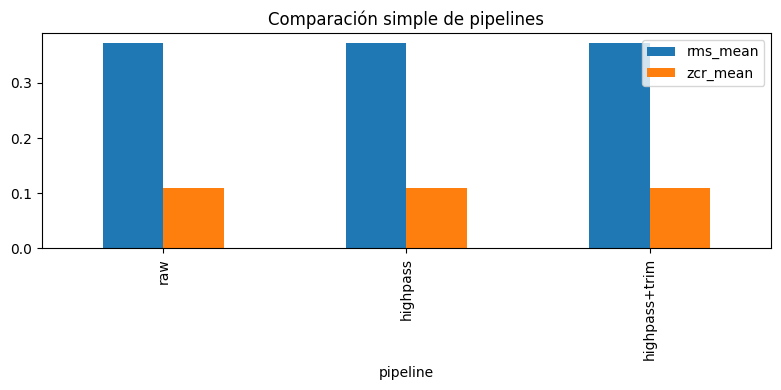

In [19]:
def pipeline_raw(y, sr):
    return y, "raw"

def pipeline_hp(y, sr):
    y_hp = highpass_filter(y, sr, cutoff_hz=80.0, order=4)
    return y_hp, "highpass"

def pipeline_hp_trim(y, sr):
    y_hp = highpass_filter(y, sr, cutoff_hz=80.0, order=4)
    y_trim, _ = librosa.effects.trim(y_hp, top_db=30.0)
    return y_trim, "highpass+trim"

pipelines = [pipeline_raw, pipeline_hp, pipeline_hp_trim]

metrics = []
for pipe in pipelines:
    y_out, name = pipe(y_noisy, sr_std)
    feats = extract_mfcc_features(preprocess_audio(audio_path)[0], sr_std)
    metrics.append({
        "pipeline": name,
        "rms_mean": feats["rms_mean"],
        "zcr_mean": feats["zcr_mean"],
    })

df_pipes = pd.DataFrame(metrics)
df_pipes

df_pipes.set_index("pipeline")[["rms_mean", "zcr_mean"]].plot(
    kind="bar", figsize=(8, 4), title="Comparación simple de pipelines"
)
plt.tight_layout()
plt.show()

Proponé una métrica propia (por ejemplo, energía en bajas frecuencias) y evaluá cuál pipeline te parece mejor.

### F.3 Dashboard QA de audio


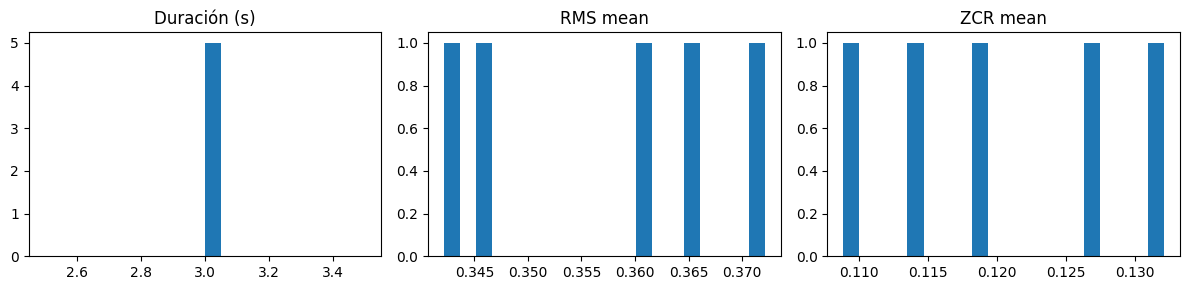

In [20]:
rows_qc = []
for path in audio_files[:200]:  # limitar a 200 para ir rápido
    y_proc, sr_proc = preprocess_audio(path)
    feats = extract_mfcc_features(y_proc, sr_proc)
    feats["filename"] = path.name
    feats["duration_sec"] = TARGET_DURATION
    feats["rms_mean"] = float(np.mean(librosa.feature.rms(y=y_proc)))
    feats["zcr_mean"] = float(np.mean(librosa.feature.zero_crossing_rate(y=y_proc)))
    rows_qc.append(feats)

df_qc = pd.DataFrame(rows_qc)
df_qc.describe()[["duration_sec", "rms_mean", "zcr_mean"]]

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
axes[0].hist(df_qc["duration_sec"], bins=20)
axes[0].set_title("Duración (s)")
axes[1].hist(df_qc["rms_mean"], bins=20)
axes[1].set_title("RMS mean")
axes[2].hist(df_qc["zcr_mean"], bins=20)
axes[2].set_title("ZCR mean")
plt.tight_layout()
plt.show()